# Методы сбора и обработки данных из сети интернет
## Урок 4. Парсинг HTML. XPath
### Задание
1. Написать приложение, которое собирает основные новости с сайтов mail.ru, lenta.ru, yandex.news.
2. Для парсинга использовать xpath. Структура данных должна содержать: 
    * название источника,
    * наименование новости,
    * ссылку на новость,
    * дата публикации.
3. Сложить все новости в БД.

### Запуск MongoDB

In [1]:
!docker start scrapy_mongo

scrapy_mongo


### Скрапперы

In [2]:
import requests
from fake_useragent import UserAgent
from lxml import html, etree
from datetime import datetime
import unicodedata
import locale

locale.setlocale(locale.LC_TIME, 'ru_RU.UTF-8')

'ru_RU.UTF-8'

Базовый класс:

In [19]:
class BaseScrapper:

    def __init__(self, host: str, user_agent: str = UserAgent().random):
        self._host: str = host
        self._user_agent = user_agent
        self._data_to_return: list = None
        self._current_pos: int = -1

    def __iter__(self) -> iter:
        return self

    def __next__(self):
        if self._data_to_return is None:
            self._data_to_return = self._fetch_data()
        self._current_pos += 1
        if self._current_pos >= len(self._data_to_return):
            raise StopIteration
        return self._data_to_return[self._current_pos]
        
    def _fetch_data(self) -> set:
        page = self._get_page()
        data = self._extract_data(page)
        return data

    def _get_page(self) -> html.HtmlElement:
        headers = {'User-Agent': self._user_agent,}
        content = requests.get(self._host, headers=headers).text
        parsed = html.fromstring(content)
        return parsed

    def _extract_data(self, parsed: html.HtmlElement) -> list:
        result = []
        articles = self._get_articles(parsed)
        for article in articles:
            try:
                result.append(self._extract_data_elem(article))
            except Exception as e:
                print('Article:', etree.tostring(article))
                raise e
        return result
    
    def _get_articles(self, parsed: html.HtmlElement) -> list:
        raise NotImplementedError
    
    def _extract_data_elem(self, article: html.HtmlElement) -> dict:
        raise NotImplementedError
    
    def __repr__(self) -> str:
        return '{clazz}({sep}host={host},{sep}fetched={fetched},\n)'.format(
            sep='\n\t',
            clazz=self.__class__.__name__,
            host=self._host,
            fetched=(self._data_to_return is not None),
        )

Скраппер mail.ru:

In [20]:
class MailRuScrapper(BaseScrapper):

    def __init__(self):
        super().__init__(host='https://news.mail.ru')

    def _get_articles(self, parsed: html.HtmlElement) -> list:
        return parsed.xpath('//div[contains(@class,"newsitem_height")]')

    def _extract_data_elem(self, article: html.HtmlElement) -> dict:
        return {
            'raw': etree.tostring(article),
            'url': self._host + article.xpath('.//span[@class="cell"]/a[@class="newsitem__title link-holder"]/@href')[0], 
            'header': unicodedata.normalize('NFKD', article.xpath('.//span[@class="newsitem__title-inner"]/text()')[0]),
            'date': datetime.strptime(article.xpath('.//div[@class="newsitem__params"]/span[contains(@class,"js-ago")]/@datetime')[0], '%Y-%m-%dT%H:%M:%S%z'),
            'source': unicodedata.normalize('NFKD', article.xpath('.//div[@class="newsitem__params"]/span[@class="newsitem__param"]/text()')[0]),
        }

Скраппер lenta.ru:

In [22]:
class LentaRuScrapper(BaseScrapper):

    def __init__(self):
        super().__init__(host='https://lenta.ru')

    def _get_articles(self, parsed: html.HtmlElement) -> list:
        return parsed.xpath('//div[contains(@class,"span")]/div[@class="item"]/a[contains(@href,"/news/")]')

    def _extract_data_elem(self, article: html.HtmlElement) -> dict:
        return {
            'raw': etree.tostring(article),
            'url': self._host + article.xpath('./@href')[0], 
            'header': unicodedata.normalize('NFKD', article.xpath('./text()')[0]),
            'date': datetime.strptime(article.xpath('./time/@datetime')[0], ' %H:%M, %d %B %Y'),
            'source': 'Lenta.ru',
        }

Скраппер yandex.news:

In [23]:
class YandexNewsScrapper(BaseScrapper):

    def __init__(self):
        super().__init__(host='https://news.yandex.ru')

    def _get_articles(self, parsed: html.HtmlElement) -> list:
        return parsed.xpath('//div[@class="page-content__cell"]//table[contains(@class,"stories-set")]//td')

    def _extract_data_elem(self, article: html.HtmlElement) -> dict:
        return {
            'raw': etree.tostring(article),
            'url': self._host + article.xpath('.//h2[@class="story__title"]/a/@href')[0], 
            'header': unicodedata.normalize('NFKD', article.xpath('.//h2[@class="story__title"]/a/text()')[0]),
            'date': self.__parse_date(article),
            'source': ' '.join(article.xpath('.//div[@class="story__date"]/text()')[0].split()[0:-1]),
        }
    
    def __parse_date(self, article: html.HtmlElement) -> datetime:
        str_time = article.xpath('.//div[@class="story__date"]/text()')[0].split()[-1]
        parsed_time = datetime.strptime(str_time, '%H:%M')
        return datetime.now().replace(hour=parsed_time.hour, minute=parsed_time.minute, second=0, microsecond=0)

### Сбор данных

In [8]:
from pymongo import MongoClient

In [9]:
mongo = MongoClient('localhost', 27017)
db = mongo['news_db']

In [24]:
def fill_via_scrapper(data, collection):
    for row in data:
        if collection.update_one({'_id': row['url']}, {'$set': row}, upsert=True).matched_count != 0:
            break

In [25]:
fill_via_scrapper(MailRuScrapper(), db.news)
fill_via_scrapper(LentaRuScrapper(), db.news)
fill_via_scrapper(YandexNewsScrapper(), db.news)

### Вывод данных

In [50]:
import pandas as pd
import matplotlib.pyplot as plt
pd.options.display.max_colwidth = -1
%config InlineBackend.figure_format = 'jpeg'
%matplotlib inline

Выведем 5 самых последних новостей:

In [53]:
df = pd.DataFrame([x for x in db.news.find({}, {'_id': 0, 'raw': 0})])

In [54]:
df.sort_values('date', ascending=False).head(5)

,date,header,source,url
31,2020-01-05 23:59:00,Зариф назвал Помпео «высокомерным клоуном»,Газета.Ru,https://news.yandex.ru/news/story/Zarif_nazval_Pompeo_vysokomernym_klounom--4a0b5da2bfd9cfd50f92ecd748b2d57d?lr=10716&lang=ru&stid=MUjED2BPx0drbbqqWaqt&persistent_id=83904047&rubric=politics&from=index
54,2020-01-05 23:58:00,Модель обвинила Никаса Сафронова в изнасиловании и отправилась в СИЗО,Lenta.ru,https://news.yandex.ru/news/story/Model_obvinila_Nikasa_Safronova_v_iznasilovanii_i_otpravilas_v_SIZO--87c5b63bc8b2dd36f01a204c5015006c?lr=10716&lang=ru&stid=0A7msPB2Jy5tzYIDr_3R&persistent_id=83887732&rubric=incident&from=index
33,2020-01-05 23:57:00,В США у стен Белого дома прошла демонстрация против войны с Ираном,REGNUM,https://news.yandex.ru/news/story/V_SSHA_u_sten_Belogo_doma_proshla_demonstraciya_protiv_vojny_s_Iranom--3007ed185137d497fed46df88d765e54?lr=10716&lang=ru&stid=1XO3pNqkWFMFra6An_Xg&persistent_id=83907080&rubric=politics&from=index
18,2020-01-05 23:55:00,Синоптики предрекли новые погодные аномалии по всей России,Lenta.ru,https://news.yandex.ru/news/story/Sinoptiki_predrekli_novye_pogodnye_anomalii_po_vsej_Rossii--c93e4a7721dc23ebd3be7f2e0ff4890f?lr=10716&lang=ru&stid=ZDsFQ4joMA9lfWiqQ2ek&persistent_id=83877129&rubric=index&from=index
24,2020-01-05 23:55:00,Нападением под Парижем занялась антитеррористическая прокуратура,РИА Новости,https://news.yandex.ru/news/story/Napadeniem_pod_Parizhem_zanyalas_antiterroristicheskaya_prokuratura--05cc73fde1f8e5c0b8a5b09dcba5368c?lr=10716&lang=ru&stid=lFd2ZWQHA17A&persistent_id=83908907&rubric=personal_feed&from=index


Найдём самые цитируемые новостные агенства:

In [79]:
source_df = df.groupby('source')['url'].count().sort_values(ascending=False)

In [94]:
source_top10 = source_df[:9].append(pd.Series(data={'Другие': source_df[9:].sum()}))

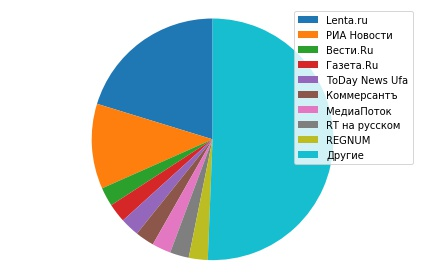

In [99]:
# The slices will be ordered and plotted counter-clockwise.
patches, texts = plt.pie(source_top10.values, startangle=90)
plt.legend(patches, source_top10.index, loc="best")
# Set aspect ratio to be equal so that pie is drawn as a circle.
plt.axis('equal')
plt.tight_layout()
plt.show()

### Завершение MongoDB

In [100]:
!docker stop scrapy_mongo

scrapy_mongo
